In [ ]:
# for InES Seminar Explaibiibility of AI in image classification context
# 19.02.2022
# GitHub link: https://github.com/jacobgil/keras-grad-cam/blob/master/grad-cam.py
#              https://github.com/marcotcr/lime/blob/master/doc/notebooks/Tutorial%20-%20Image%20Classification%20Keras.ipynb

In [1]:
from keras.applications.vgg19 import (
    VGG19, preprocess_input, decode_predictions)

from keras.applications.vgg16 import (
    VGG16, preprocess_input, decode_predictions)

import lime
from lime import lime_image
from skimage.segmentation import mark_boundaries
from keras.applications import inception_v3 as inc_net

from keras.preprocessing import image
from keras.layers.core import Lambda
from keras.models import Sequential
from tensorflow.python.framework import ops
from keras.models import Model
import keras.backend as K
import tensorflow as tf
import numpy as np
import keras
import sys
import cv2
from matplotlib import pyplot as plt
tf.compat.v1.disable_eager_execution()
inet_model = inc_net.InceptionV3()

Instructions for updating:
Colocations handled automatically by placer.


In [43]:
def target_category_loss(x, category_index, nb_classes):
    return tf.multiply(x, K.one_hot([category_index], nb_classes))

def target_category_loss_output_shape(input_shape):
    return input_shape

def normalize(x):
    # utility function to normalize a tensor by its L2 norm
    return x / (K.sqrt(K.mean(K.square(x))) + 1e-5)

def load_image(path):
    #img_path = sys.argv[1]
    img = image.load_img(path, target_size=(224, 224))
    x = image.img_to_array(img).astype(np.uint8)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    return x

def register_gradient():
    if "GuidedBackProp" not in ops._gradient_registry._registry:
        @ops.RegisterGradient("GuidedBackProp")
        def _GuidedBackProp(op, grad):
            dtype = op.inputs[0].dtype
            return grad * tf.cast(grad > 0., dtype) * \
                tf.cast(op.inputs[0] > 0., dtype)

def compile_saliency_function(model, activation_layer='block5_conv3'):
    input_img = model.input
    layer_dict = dict([(layer.name, layer) for layer in model.layers[1:]])
    layer_output = layer_dict[activation_layer].output
    max_output = K.max(layer_output, axis=3)
    saliency = K.gradients(K.sum(max_output), input_img)[0]
    return K.function([input_img, K.learning_phase()], [saliency])

def modify_backprop(model, name, mods):
    g =  tf.compat.v1.get_default_graph()
    with g.gradient_override_map({'Relu': name}):

        # get layers that have an activation
        layer_dict = [layer for layer in model.layers[1:]
                      if hasattr(layer, 'activation')]

        # replace relu activation
        for layer in layer_dict:
            if layer.activation == keras.activations.relu:
                layer.activation = tf.nn.relu

        # re-instanciate a new model
        if mods == 19:
            new_model = VGG19(weights='imagenet')
        elif mods == 16:
            new_model = VGG16(weights='imagenet')


    return new_model

def deprocess_image(x):
    '''
    Same normalization as in:
    https://github.com/fchollet/keras/blob/master/examples/conv_filter_visualization.py
    '''
    if np.ndim(x) > 3:
        x = np.squeeze(x)
    # normalize tensor: center on 0., ensure std is 0.1
    x -= x.mean()
    x /= (x.std() + 1e-5)
    x *= 0.1

    # clip to [0, 1]
    x += 0.5
    x = np.clip(x, 0, 1)

    # convert to RGB array
    x *= 255
    if keras.backend.image_data_format() == 'th':
        x = x.transpose((1, 2, 0))
    x = np.clip(x, 0, 255).astype('uint8')
    return x

def _compute_gradients(tensor, var_list):
    grads = tf.gradients(tensor, var_list)
    return [grad if grad is not None else tf.zeros_like(var) for var, grad in zip(var_list, grads)]

def grad_cam(input_model, image, category_index, layer_name):
    nb_classes = 1000
    target_layer = lambda x: target_category_loss(x, category_index, nb_classes)
    x = Lambda(target_layer, output_shape = target_category_loss_output_shape)(input_model.output)
    model = Model(inputs=input_model.input, outputs=x)
    #model.summary()
    loss = K.sum(model.output)
    conv_output =  [l for l in model.layers if l.name is layer_name][0].output
    grads = normalize(_compute_gradients(loss, [conv_output])[0])
    gradient_function = K.function([model.input], [conv_output, grads])

    output, grads_val = gradient_function([image])
    output, grads_val = output[0, :], grads_val[0, :, :, :]

    weights = np.mean(grads_val, axis = (0, 1))
    cam = np.ones(output.shape[0 : 2], dtype = np.float32)

    for i, w in enumerate(weights):
        cam += w * output[:, :, i]

    cam = cv2.resize(cam, (224, 224))
    cam = np.maximum(cam, 0)
    heatmap = cam / np.max(cam)

    #Return to BGR [0..255] from the preprocessed image
    image = image[0, :]
    image -= np.min(image)
    image = np.minimum(image, 255)

    cam = cv2.applyColorMap(np.uint8(255*heatmap), cv2.COLORMAP_JET)
    cam = np.float32(cam) + np.float32(image)
    cam = 255 * cam / np.max(cam)
    return np.uint8(cam), heatmap

def limePics(path):

    explainer = lime_image.LimeImageExplainer()
    img = image.load_img(path, target_size=(224, 224))
    x = image.img_to_array(img).astype(np.uint8)
    x1 = np.expand_dims(x, axis=0)
    x1 = preprocess_input(x1)
    x = preprocess_input(x)

    model = VGG16(weights='imagenet')

    
    preds = model.predict(x1)
    for i in decode_predictions(preds)[0]:
        print(i)
    explanation = explainer.explain_instance(x.astype('double'), 
                                             model.predict, 
                                             top_labels=5, 
                                             hide_color=0, 
                                             num_samples=1000)
    return explanation


def showLime(explanation, index, name):    
    #temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=10, hide_rest=True)
    temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=5, hide_rest=True)
    
    plt.imshow(mark_boundaries(temp.astype('uint8'), mask))
    cv2.imwrite("lime_16_"+str(name)+".jpg", deprocess_image(mark_boundaries(temp / 2 + 0.5, mask)))
    

In [24]:
path = "Images//ILSVRC2012_val_00000007.JPEG"

preprocessed_input = load_image(path)



UnboundLocalError: local variable 'x' referenced before assignment

In [21]:
model = VGG19(weights='imagenet')

index = 1

predictions = model.predict(preprocessed_input)
top_1 = decode_predictions(predictions)[0][index]
top_2 = decode_predictions(predictions)[0][index+1]
top_3 = decode_predictions(predictions)[0][index+2]


print('Predicted class:')
print('%s (%s) with probability %.2f' % (top_1[1], top_1[0], top_1[2]))

print('%s (%s) with probability %.2f' % (top_2[1], top_2[0], top_2[2]))
print('%s (%s) with probability %.2f' % (top_3[1], top_3[0], top_3[2]))



predicted_class = np.argsort(np.max(predictions, axis=0))[-(index+1)]
print(predicted_class)


cam, heatmap = grad_cam(model, preprocessed_input, predicted_class, "block5_conv3")
cv2.imwrite("gradcam_19_"+str(top_1[1])+".jpg", cam)

register_gradient()
guided_model = modify_backprop(model, 'GuidedBackProp', mods = 19)
saliency_fn = compile_saliency_function(guided_model)
saliency = saliency_fn([preprocessed_input, 0])
gradcam = saliency[0] * heatmap[..., np.newaxis]
cv2.imwrite("guided_gradcam_19_"+str(top_1[1])+".jpg", deprocess_image(gradcam))

KeyboardInterrupt: 

In [22]:
model = VGG16(weights='imagenet')
index = 0

predictions = model.predict(preprocessed_input)
top_1 = decode_predictions(predictions)[0][index]
top_2 = decode_predictions(predictions)[0][index+1]
top_3 = decode_predictions(predictions)[0][index+2]


print('Predicted class:')
print('%s (%s) with probability %.2f' % (top_1[1], top_1[0], top_1[2]))

print('%s (%s) with probability %.2f' % (top_2[1], top_2[0], top_2[2]))
print('%s (%s) with probability %.2f' % (top_3[1], top_3[0], top_3[2]))

predicted_class = np.argsort(np.max(predictions, axis=0))[-(index+1)]
print(predicted_class)
print(str(top_1[1]))

cam, heatmap = grad_cam(model, preprocessed_input, predicted_class, "block5_conv3")
cv2.imwrite("gradcam_16_"+str(top_1[1])+".jpg", cam)

register_gradient()
guided_model = modify_backprop(model, 'GuidedBackProp', mods = 16)
saliency_fn = compile_saliency_function(guided_model)
saliency = saliency_fn([preprocessed_input, 0])
gradcam = saliency[0] * heatmap[..., np.newaxis]
cv2.imwrite("guided_gradcam_16_"+str(top_1[1])+".jpg", deprocess_image(gradcam))
cv2.imwrite("normal_image_"+str(top_1[1])+".jpg", deprocess_image(preprocessed_input))

Predicted class:
zebra (n02391049) with probability 1.00
gazelle (n02423022) with probability 0.00
cheetah (n02130308) with probability 0.00
340
zebra


True

In [40]:
#path = "Images//parrot.jpeg"
exp = limePics(path)

/Users/patrickknab/opt/anaconda3/envs/INES/lib/python3.8/site-packages/keras/engine/training.py:2401: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


('n02391049', 'zebra', 0.9994981)
('n02423022', 'gazelle', 0.0002864977)
('n02130308', 'cheetah', 8.73004e-05)
('n02422106', 'hartebeest', 6.483199e-05)
('n02422699', 'impala', 4.45721e-05)


  0%|          | 0/1000 [00:00<?, ?it/s]

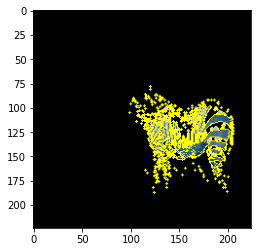

In [44]:
showLime(exp, 0, str(top_1[1]))

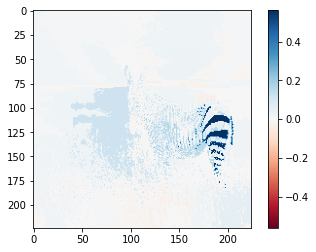

In [50]:
explanation = exp

#Select the same class explained on the figures above.
ind =  explanation.top_labels[0]

#Map each explanation weight to the corresponding superpixel
dict_heatmap = dict(explanation.local_exp[ind])
heatmap = np.vectorize(dict_heatmap.get)(explanation.segments) 

#Plot. The visualization makes more sense if a symmetrical colorbar is used.
plt.imshow(heatmap, cmap = 'RdBu', vmin  = -heatmap.max(), vmax = heatmap.max())
plt.colorbar()
plt.savefig('heatmap_zebra.png')